# Introduction

Hello, welcome to the jupyter notebook containing the code for implementing my Image Compression Algorithm analysis. 

This notebook contains code segmented in the following sections:
1. Import Packages
2. Access Image Dataset
3. Function to convert Image to Greyscale
4. Plot Histogram of Pixel Intensity & Frequency for each image
5. Calculate Shannon Entropy of each image
6. SVD compression & binary searching functions
7. FT compression & binary searching functions
8. SVD & FFT for all images at sample compression ratio of 1.5
9. Function to calculate PSNR for compressed images
10. Plot PSNR & Computation Time for SVD & FFT on top 3 candidate images

Each section contains an additional description of the code functionality and workflow, based on how complex the code might be. Thank you!

# Import Packages

In [19]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import imageio
import time
import os

from skimage import data
from skimage import color

# Access Image Dataset

Our image dataset is accessed through the skimage API. Because we chose to work with skimage's "General Images" collection, we have to type in the names of the 18 images that belong to that collection, under the "images" tuple below. Then, we access attributes that belong to each image, such as the image and name, using the getattr() function. Finally, we plot the images to see what they look like.

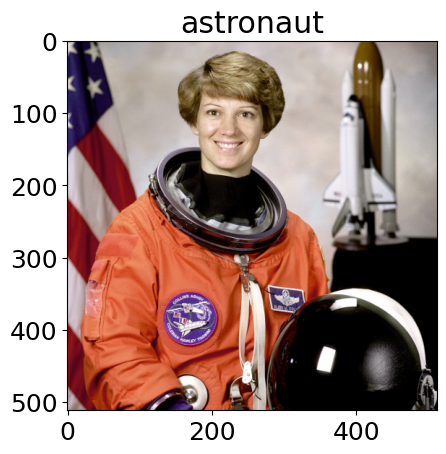

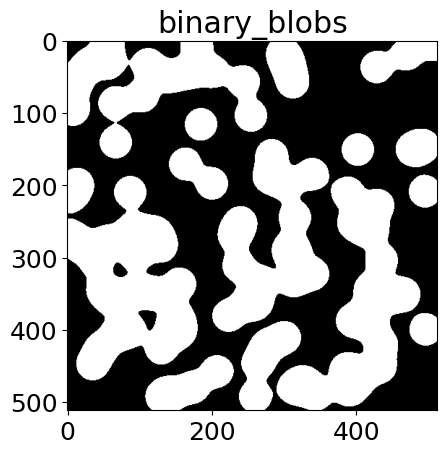

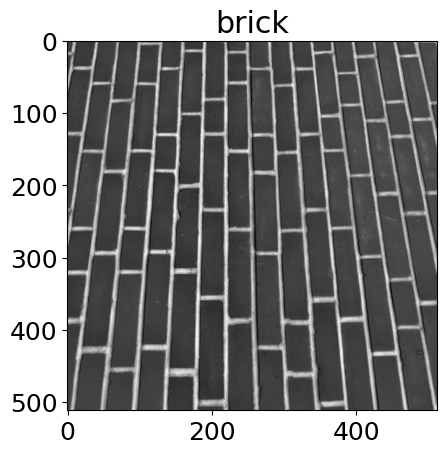

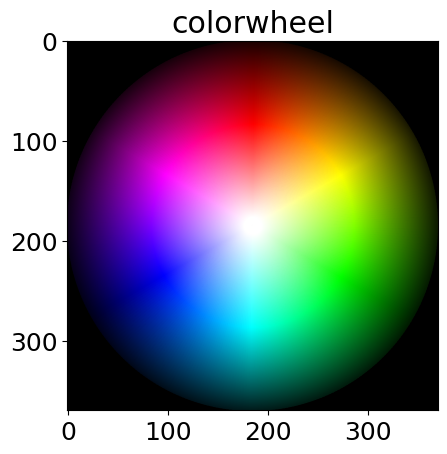

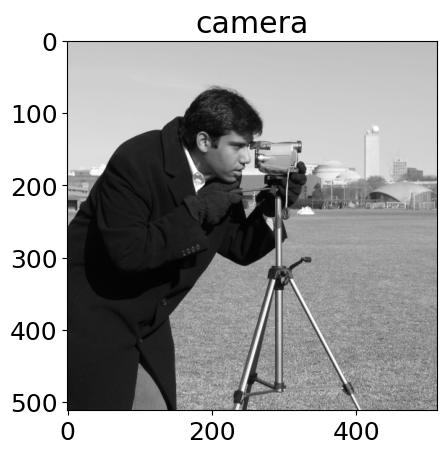

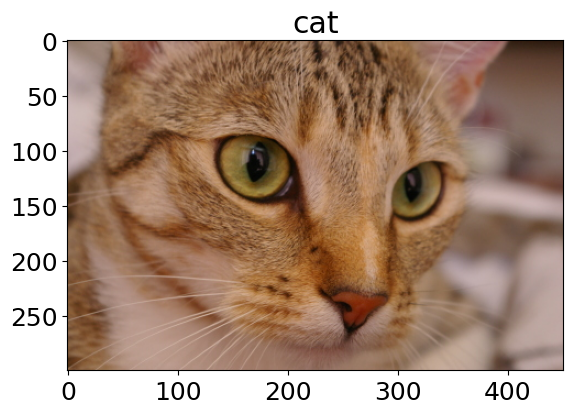

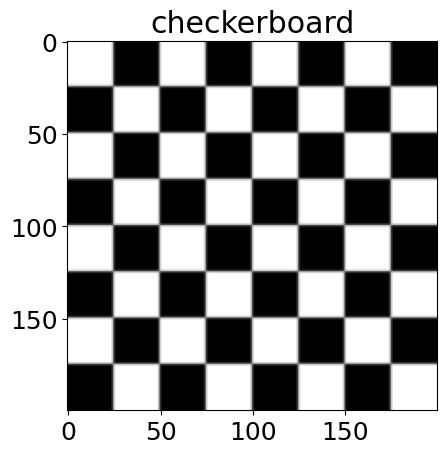

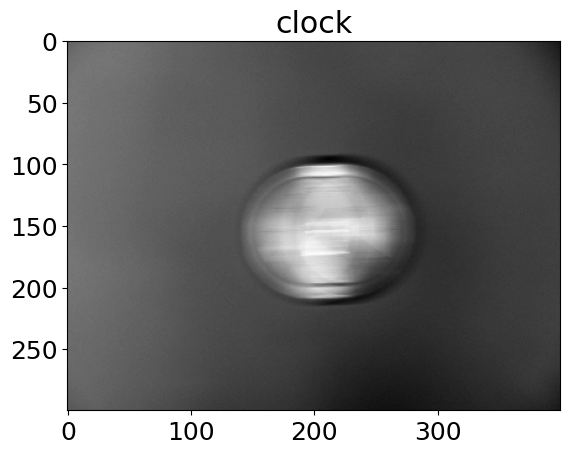

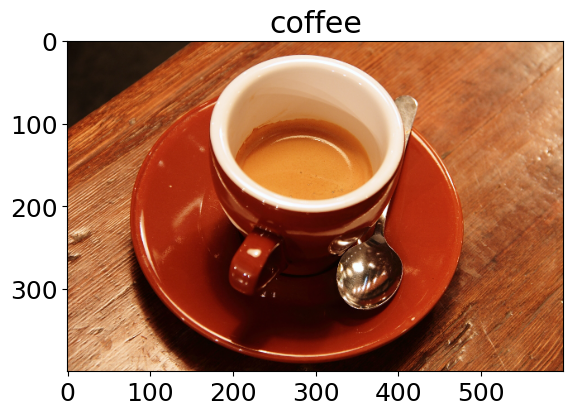

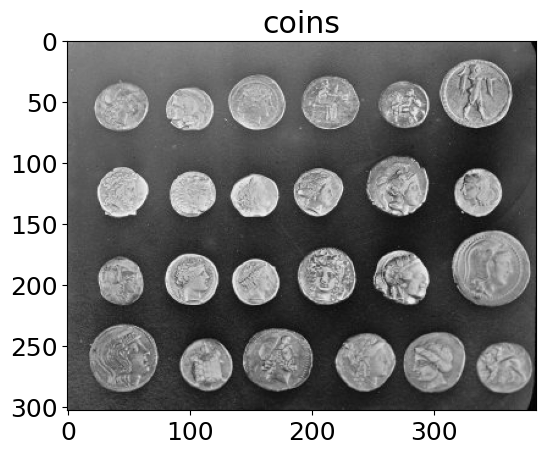

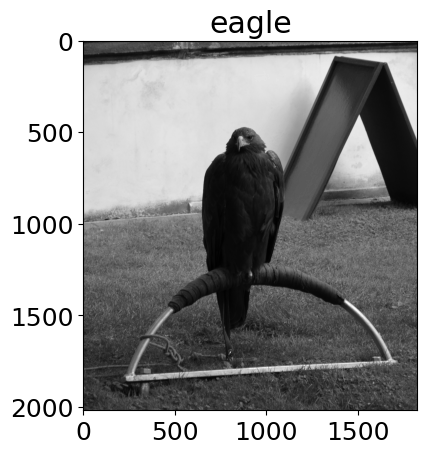

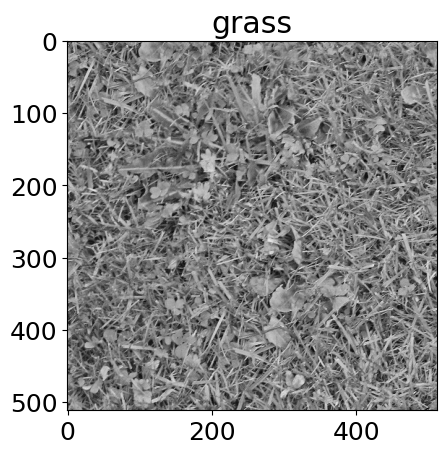

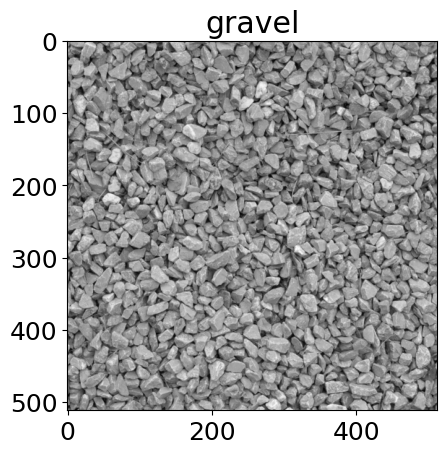

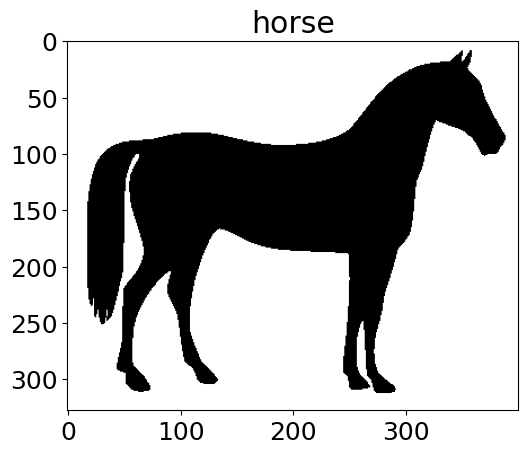

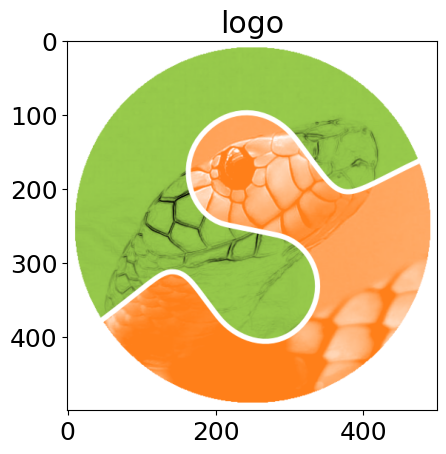

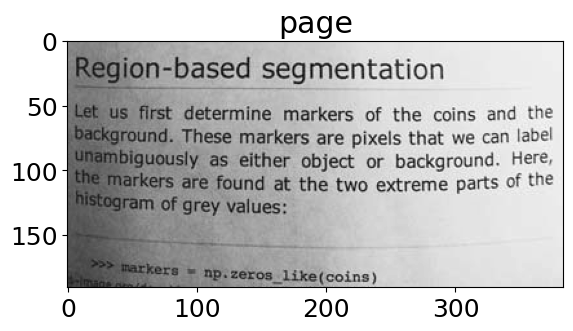

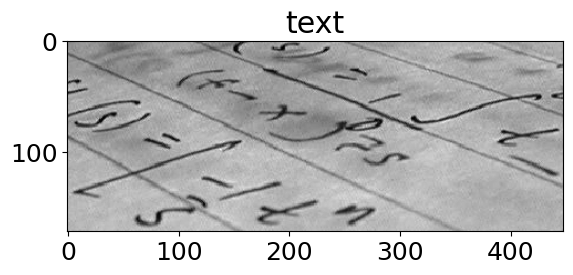

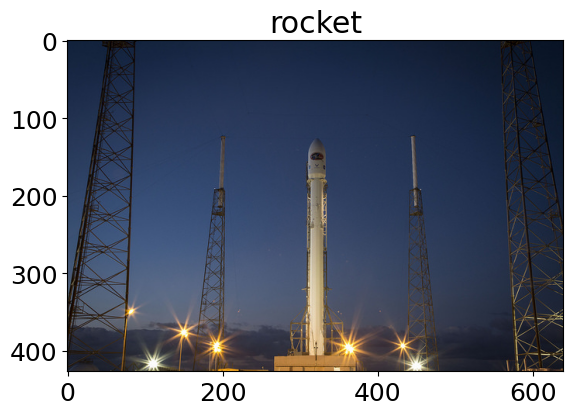

In [20]:
matplotlib.rcParams['font.size'] = 18

images = (
    'astronaut',
    'binary_blobs',
    'brick',
    'colorwheel',
    'camera',
    'cat',
    'checkerboard',
    'clock',
    'coffee',
    'coins',
    'eagle',
    'grass',
    'gravel',
    'horse',
    'logo',
    'page',
    'text',
    'rocket',
)


for name in images:
    caller = getattr(data, name)
    image = caller()
    plt.figure()
    plt.title(name)
    if image.ndim == 2:
        plt.imshow(image, cmap=plt.cm.gray)
    else:
        plt.imshow(image)

plt.show()


# Function to convert Image to Greyscale 

Some of the images in the dataset come in grayscale, RGB and even RGBA. In order to have consistency and simplicity when working with these images, we chose to convert all of them to grayscale, in uint8 format. To handle that conversion, we wrote the following function, image_to_grayscale, which handles the varying dimensionality of each grayscale, RGB, and RGBA image.

In [21]:
def image_to_greyscale(image_array):
    
    if image_array.ndim == 3:
        if image_array.shape[2] == 3:  # Convert RGB to grayscale
            image_grey = color.rgb2gray(image_array)  
            image_grey = (image_grey * 255).astype(np.uint8)
            
        elif image_array.shape[2] == 4:  # Convert RGBA to grayscale by ignoring the alpha channel
            image_grey = color.rgb2gray(image_array[..., :3])  # Only take the RGB channels
            image_grey = (image_grey * 255).astype(np.uint8)
            
        else:
            raise ValueError("Unsupported number of channels. Must be 3 (RGB) or 4 (RGBA).")

    # Handle binary images
    elif image_array.ndim == 2 and image_array.dtype == bool:
        image_grey = image_array.astype(np.uint8) * 255  # Convert True to 255 and False to 0

    # Handle grayscale images
    elif image_array.ndim == 2 and image_array.dtype == np.uint8:
        image_grey = image_array  # Already grayscale

    else:
        raise ValueError("Unsupported image format or dtype")

    return image_grey


# Plot Histogram of Pixel Intensity & Frequency for each image

Here, we plot the frequency of the pixel intensity within each image matrix. These histogram plots will allow us to understand the general complexity of each grayscale image.

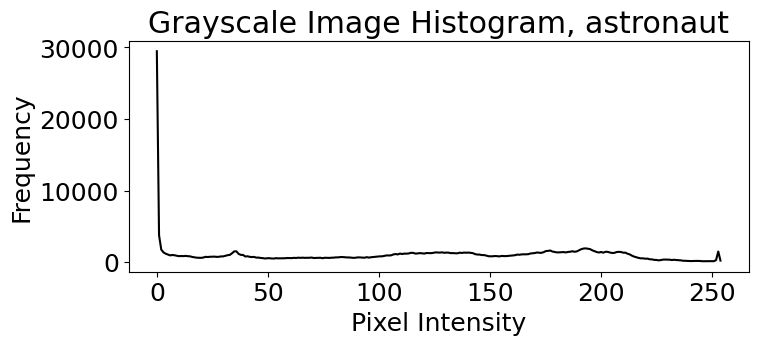

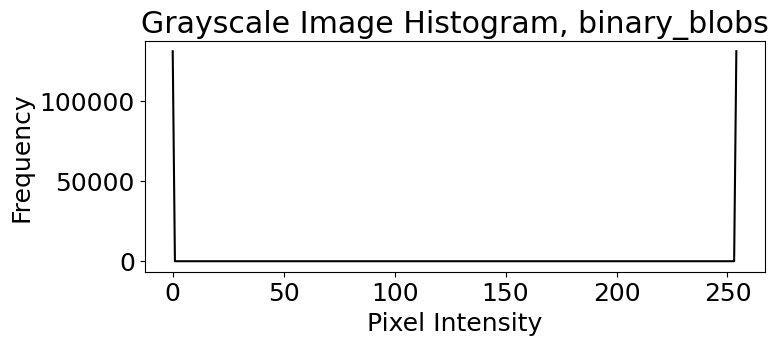

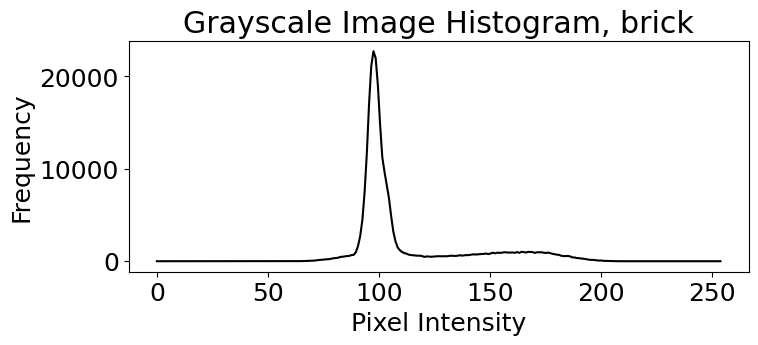

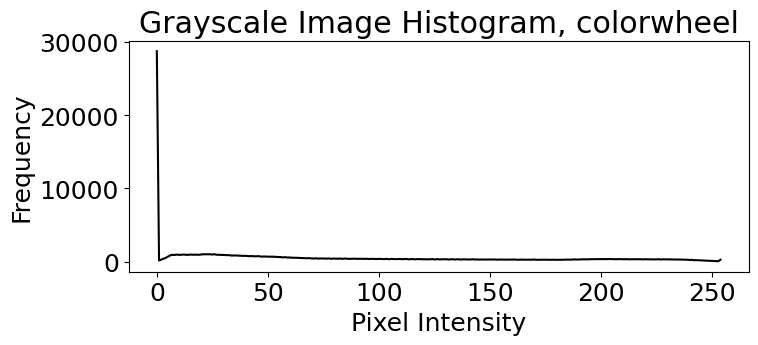

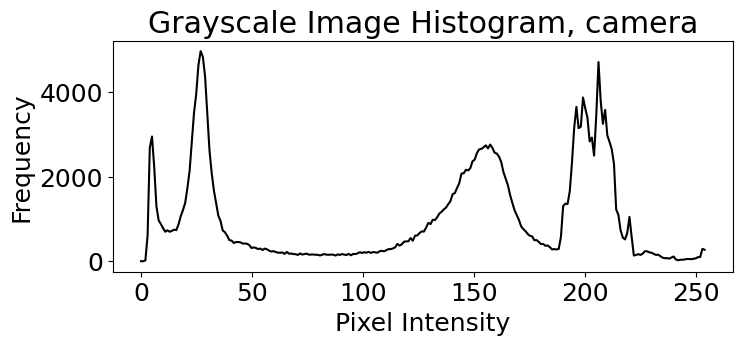

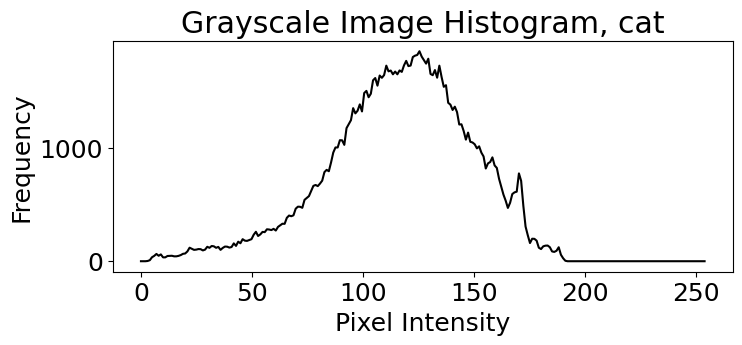

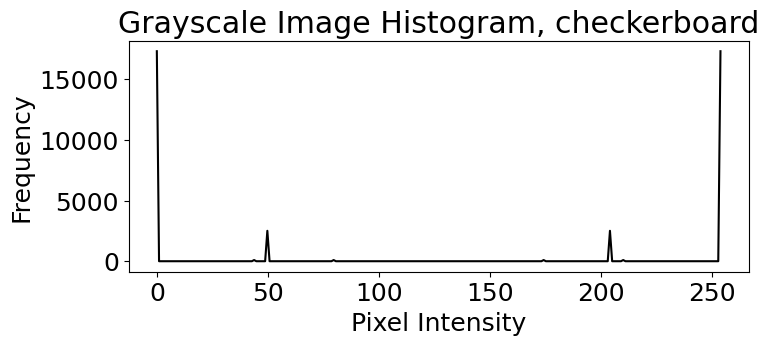

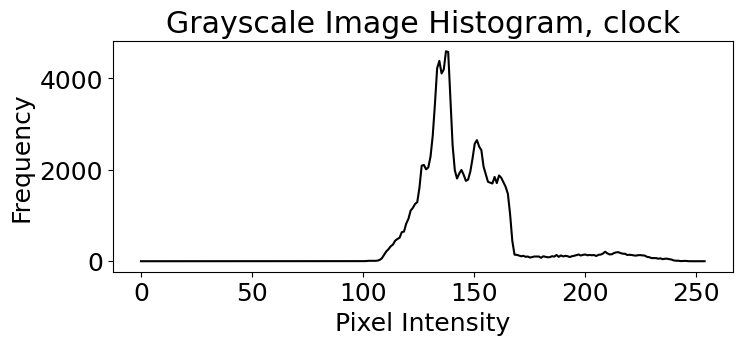

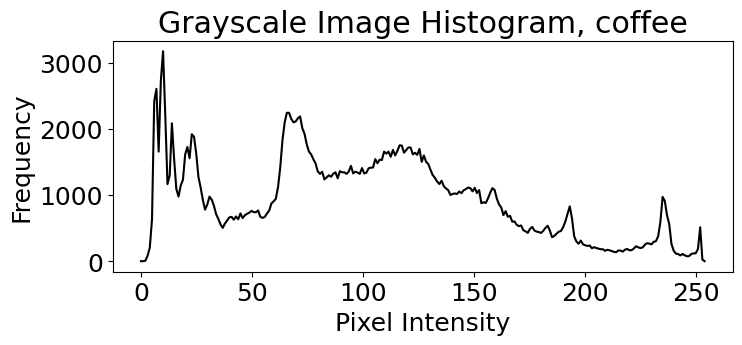

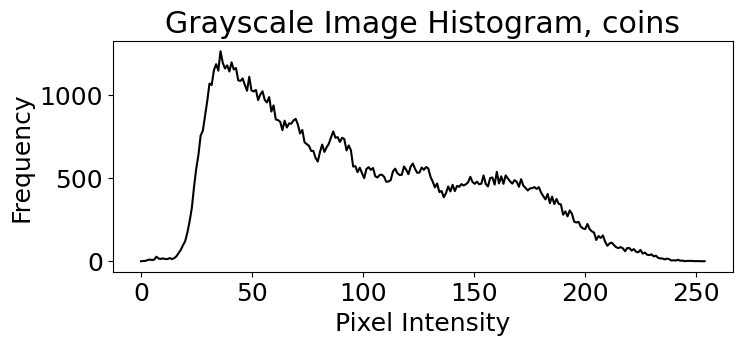

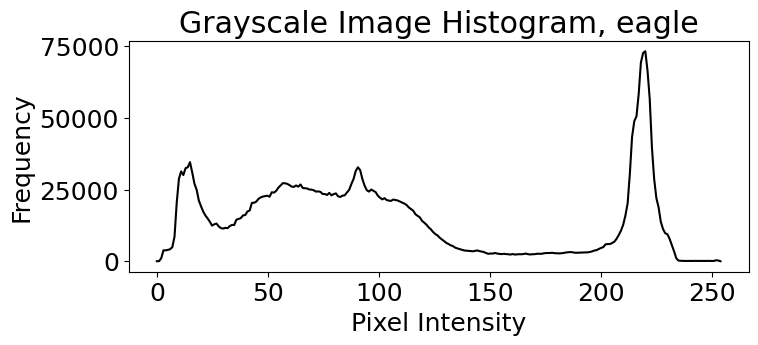

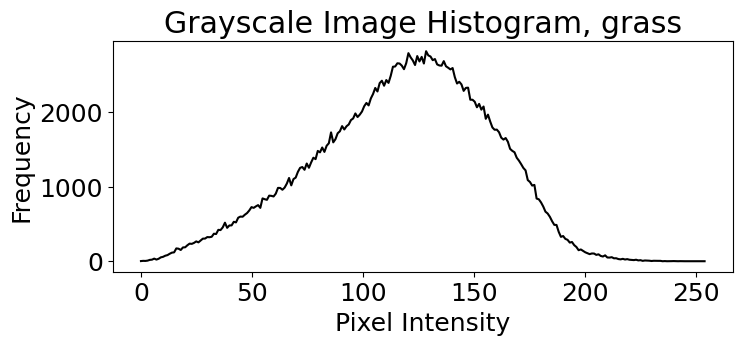

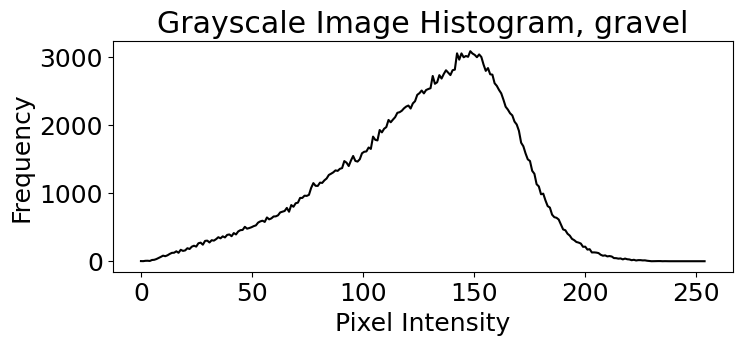

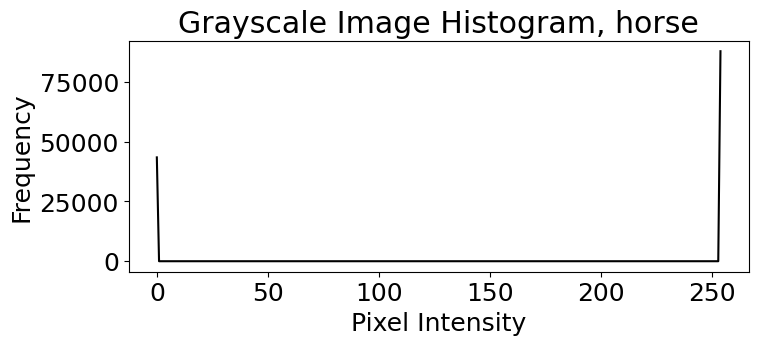

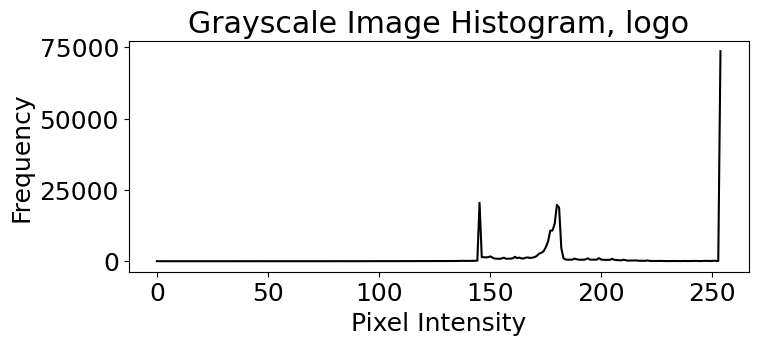

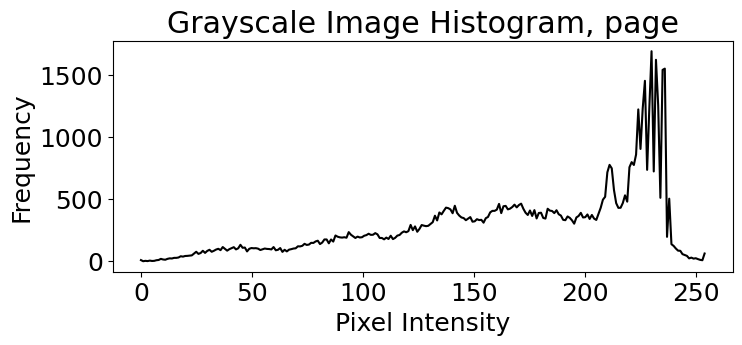

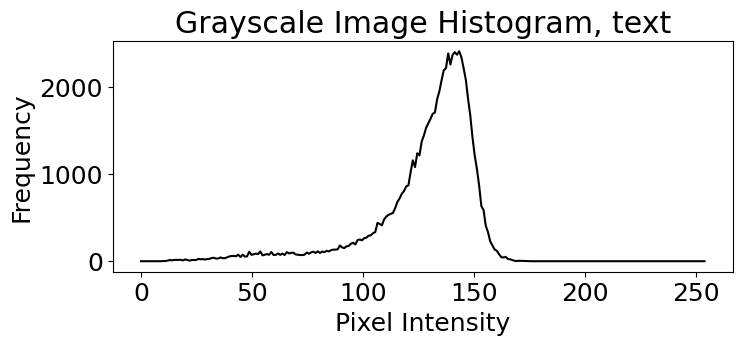

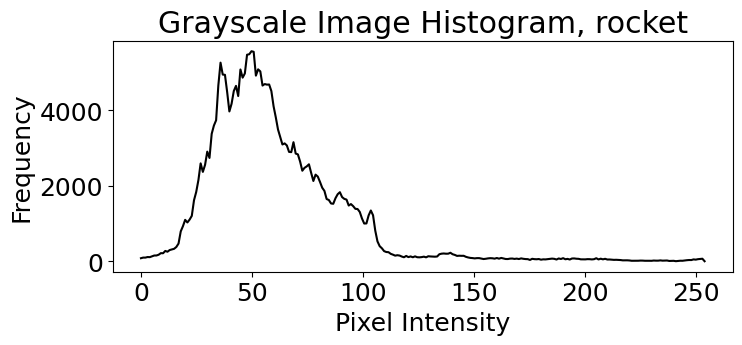

In [22]:


def pixel_histogram(image_grey, name):
    
    # Calculate the histogram
    hist, bin_edges = np.histogram(image_grey, bins=256, range=(0, 255))

    # Plot the histogram
    plt.figure(figsize=(8, 3))
    plt.plot(bin_edges[:-1], hist, color="black")  # bin_edges[:-1] aligns with hist
    plt.title("Grayscale Image Histogram, "+ name)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()


# Example usage
for name in images:
    image_array = getattr(data, name)()
    image_grey = image_to_greyscale(image_array)
    pixel_histogram(image_grey, name)



# Calculate Shannon Entropy of each image

Now, we quantify the complexity of each grayscale image by calculating the shannon entropy from pixel intensity values. 

In [23]:

def calculate_entropy(image_grey, name):

    # Calculate the histogram
    hist, bin_edges = np.histogram(image_grey, bins=256, range=(0, 255))
    
    # Normalize the histogram to get probabilities
    hist_normalized = hist / hist.sum()
    
    # Remove zero probabilities to avoid log2(0)
    hist_nonzero = hist_normalized[hist_normalized > 0]
    
    # Compute entropy
    entropy = -np.sum(hist_nonzero * np.log2(hist_nonzero))
    return entropy



# Example usage
for name in images:
    image_array = getattr(data, name)()
    image_grey = image_to_greyscale(image_array)
    print(name + " " + str(calculate_entropy(image_grey, name)) )


astronaut 7.444158328824859
binary_blobs 1.0
brick 5.455265334504446
colorwheel 6.911928827078324
camera 7.231695011055704
cat 7.004601864511788
checkerboard 1.6317676229974185
clock 6.0355022558653415
coffee 7.661570369288201
coins 7.524412237976031
eagle 7.4014811794262005
grass 7.288338951598444
gravel 7.253146960346441
horse 0.9158271515170937
logo 4.548489581745522
page 7.443679900610648
text 6.13372198445881
rocket 6.669767402285822


# SVD compression & binary search functions

Here, we write the two functions: one to compress an image with SVD, and the other to find the number of singular values to filter out in order to approximate a desired compression ratio. The latter function, find_optimal_singular_values, incorporates a binary search through all possible singular values to find how many to filter out.

In [24]:
def svd_image_compress(image, num_singular_values):
    
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    U_reduced = U[:, :num_singular_values]
    S_reduced = np.diag(S[:num_singular_values])
    Vt_reduced = Vt[:num_singular_values, :]

    compressed_image_float64 = np.dot(U_reduced, np.dot(S_reduced, Vt_reduced))
    compressed_image_uint8 = np.clip(compressed_image_float64, 0, 255).astype(np.uint8)

    return compressed_image_uint8


def find_optimal_singular_values(image, target_compression_ratio, tolerance = 0.01):

    U, S, Vt = np.linalg.svd(image, full_matrices=False)

    low, high = 1, S.shape[0]
    num_singular_values = len(S)

    # Save original image to get its size
    original_image_filename = 'original_image.png'
    imageio.imwrite(original_image_filename, image)
    original_image_size = os.path.getsize(original_image_filename)

    # iteration = 0
    
    while low <= high:
        mid = (low + high) // 2
        
        # Compress image using mid value
        compressed_image_uint8 = svd_image_compress(image,mid)
        
        # Save the compressed image to calculate size
        compressed_image_filename = f'temp_compressed_image_{name}.png'
        imageio.imwrite(compressed_image_filename, compressed_image_uint8)
        compressed_image_size = os.path.getsize(compressed_image_filename)
    
        # Calculate the current compression ratio
        current_compression_ratio = round(original_image_size / compressed_image_size, 2)
        
        # Use the desired compression ratio to adjust the search bounds
        if abs(target_compression_ratio - current_compression_ratio) <= tolerance:
            num_singular_values = mid
            break
            
        elif current_compression_ratio < target_compression_ratio:
            num_singular_values = mid
            high = mid - 1
            
        else:
            num_singular_values = mid
            low = mid + 1

    return num_singular_values


# FT compression & binary search functions 

Here, we write the two functions: one to compress an image with FT, and the other to find the "radius" of high frequency components to filter out in order to approximate a desired compression ratio. The latter function, find_optimal_radius, incorporates a binary search through all possible radius values to find the correct amount to filter by.

In [25]:
# Basic FFT Function

def apply_fft_and_mask(image,radius):

    fft_image = np.fft.fft2(image) # Transforms image to frequency domain
    fft_shifted = np.fft.fftshift(fft_image) # Shift zero frequency component to center of spectrum
    
    # Filter High Frequency Components
    rows, cols = image.shape
    center_row, center_col = rows//2, cols//2 # Center of image
    
    mask = np.zeros((rows, cols), dtype=np.uint8) # This mask will eventually contain 1's in the area corresponding to low freqs, 0's elsewhere.
    y, x = np.ogrid[-center_row:rows-center_row, -center_col:cols-center_col] # This centers your y,x variables with "center_row, center_col"
    mask_area = x**2 + y**2 <= radius**2 
    mask[mask_area] = 1 # Set masking condition for filtering
    
    fft_shifted_filtered = fft_shifted * mask
    
    # Reconstruct compressed image with Inverse FFT
    
    fft_compressed_unshifted = np.fft.ifftshift(fft_shifted_filtered)
    compressed_image = np.fft.ifft2(fft_compressed_unshifted)
    compressed_image_real = np.abs(compressed_image) # IFFT of complex frequency domain returns complex output. We want real pixel intensity values.
    compressed_image_clipped = np.clip(compressed_image_real, 0, 255)
    compressed_image_uint8 = compressed_image_clipped.astype(np.uint8)
    
    return compressed_image_uint8


# Binary Search for correct filtering radius based off defined compression ratio

def find_optimal_radius(image, target_compression_ratio, tolerance=0.02):

    rows, cols = image.shape

    max_radius = int(np.sqrt((rows/2)**2 + (cols/2)**2))

    low, high = 0, max_radius

    original_image_filename = 'original_image.png'
    imageio.imwrite(original_image_filename, image_grey)
    original_image_size = os.path.getsize(original_image_filename)

    optimal_radius = max_radius # Default value
   
    while low <= high:

        mid = (low + high)//2

        compressed_image = apply_fft_and_mask(image, mid)
        compressed_image_filename = 'compressed_image_temp.png'
        imageio.imwrite(compressed_image_filename, compressed_image)
        compressed_image_size = os.path.getsize(compressed_image_filename)

        compression_ratio = round(original_image_size / compressed_image_size, 2)
        
        if abs(compression_ratio - target_compression_ratio) <= tolerance:
            optimal_radius = mid
            break
            
        elif compression_ratio < target_compression_ratio:
            optimal_radius = mid
            high = mid -1
            
        else:
            optimal_radius = mid
            low = mid + 1
            
    return optimal_radius

# SVD & FT for all images at sample compression ratio of 1.5

Here, we apply the above SVD and FT operations on all images in our dataset, for a sample compression ratio of 1.5. We also captured details about compressed image size (original_image_size, compressed_image_size_svd, compressed_image_size_fft) and also computation time (elapsed_time_svd, elapsed_time_fft) in preparation for our later sections involving quantitative analysis.

The print statements describing image size, compression ratio and computation time have been left in but commented out, in case the reader wants to know them.

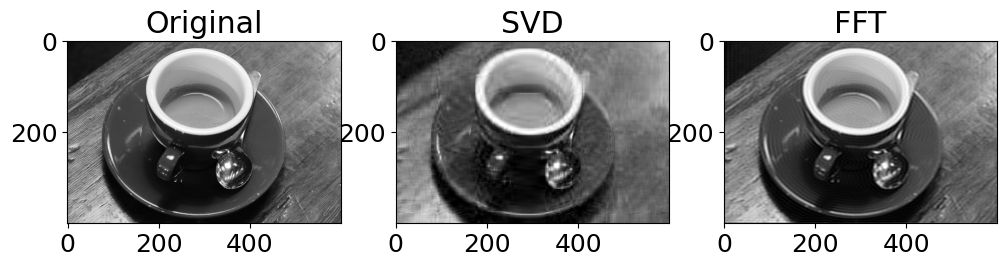

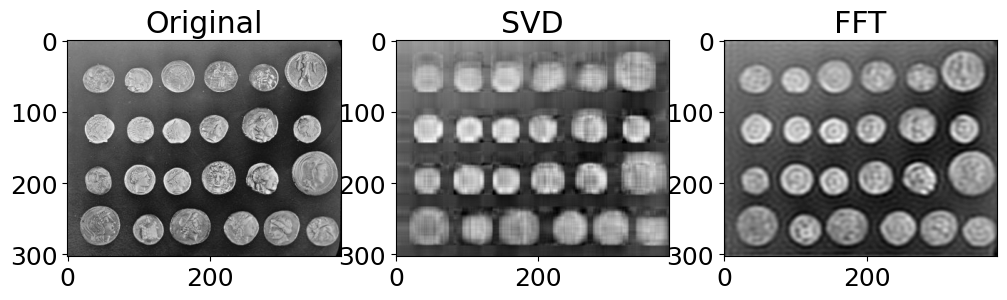

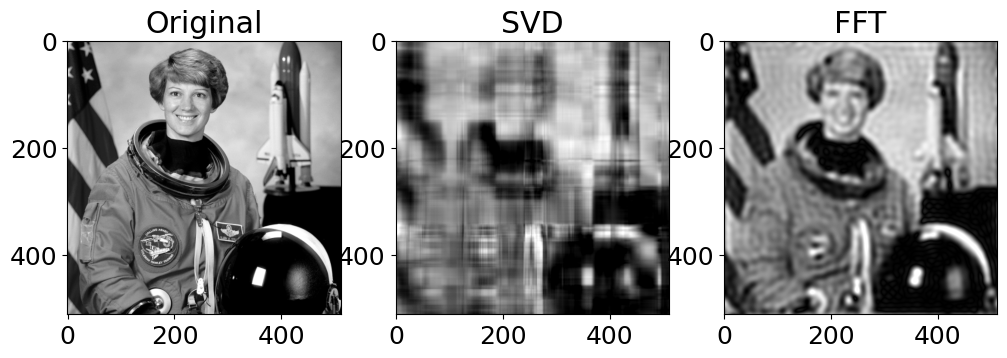

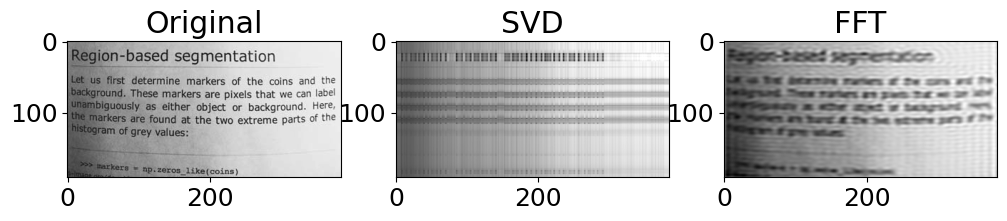

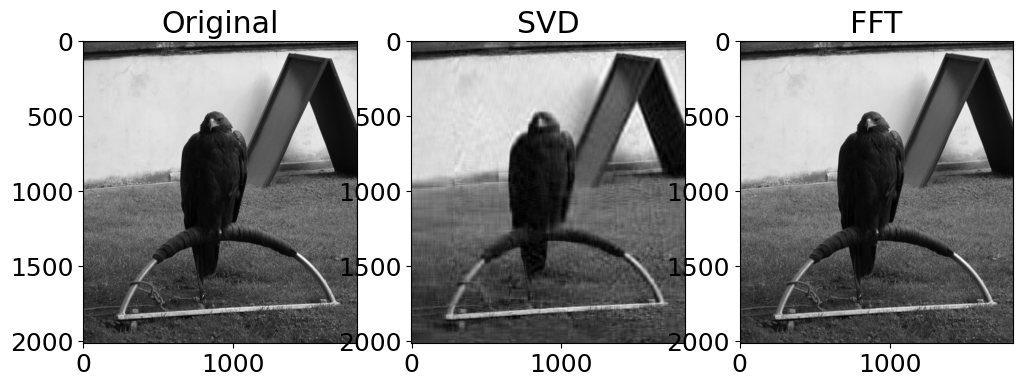

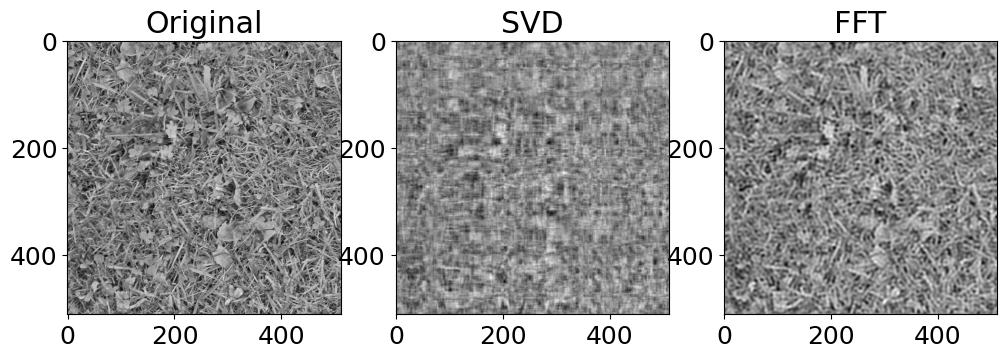

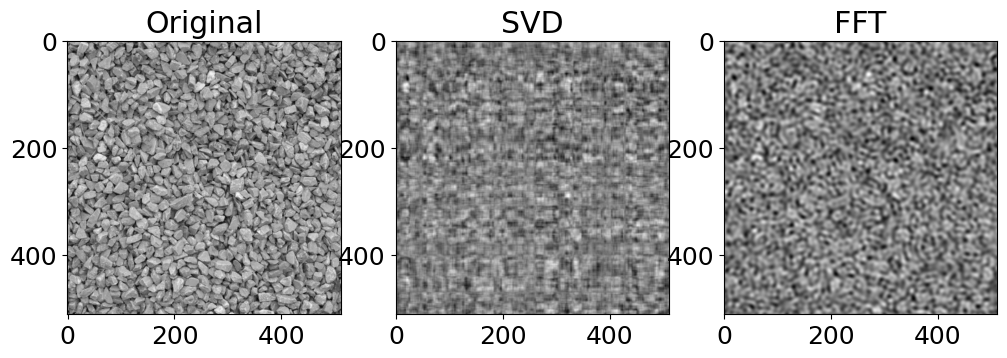

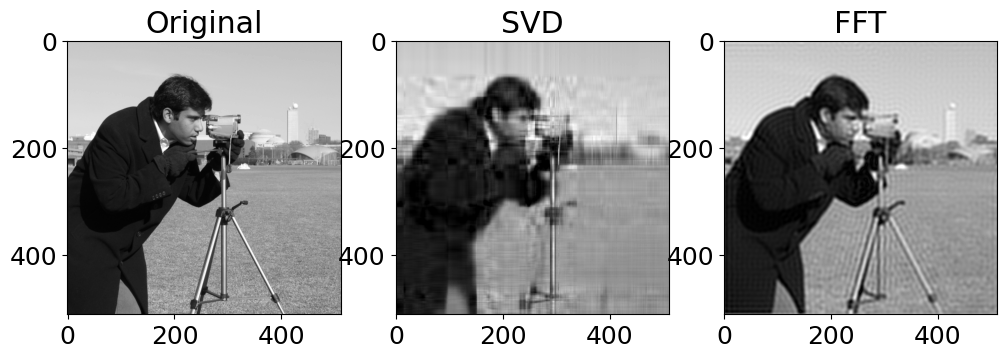

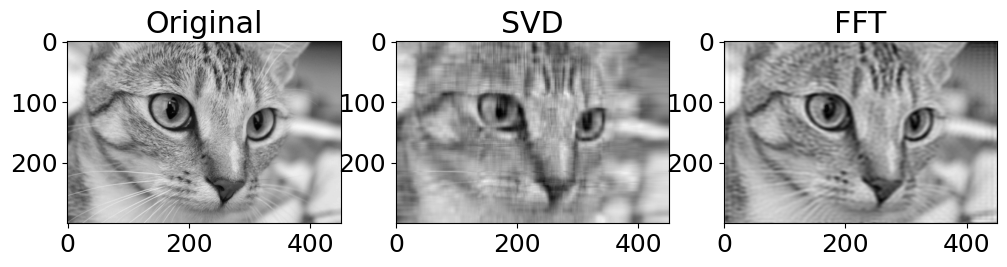

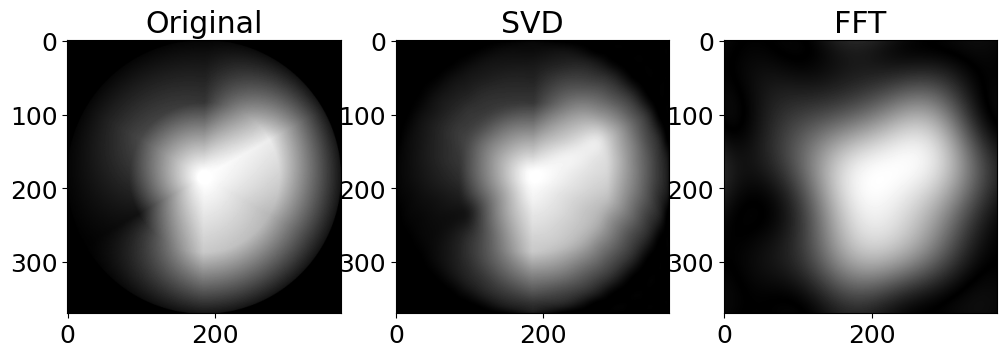

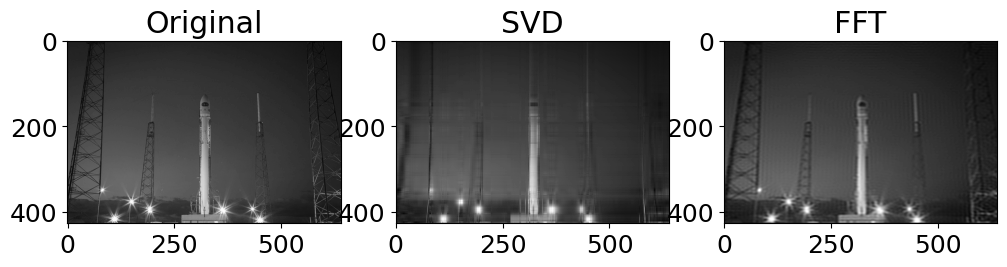

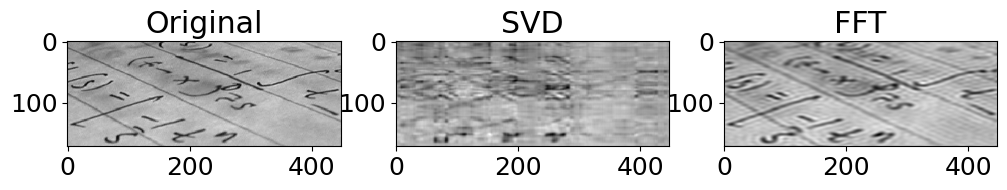

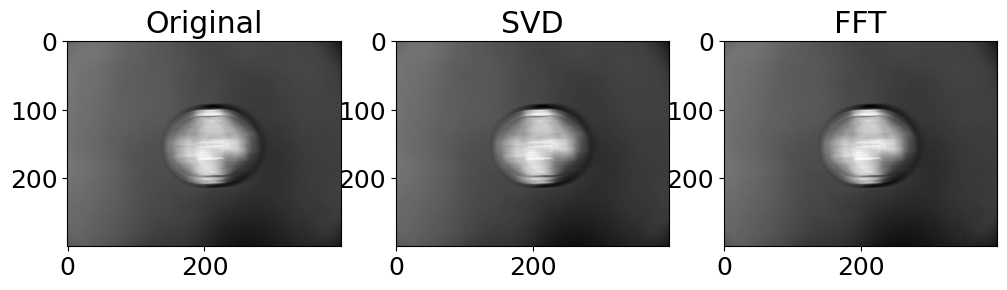

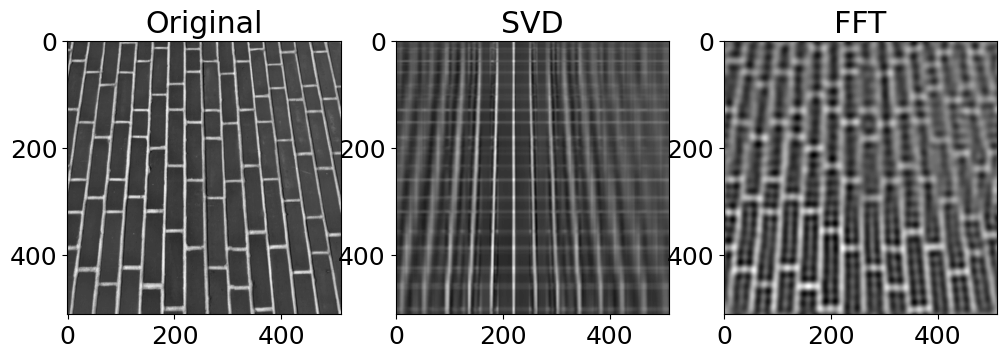

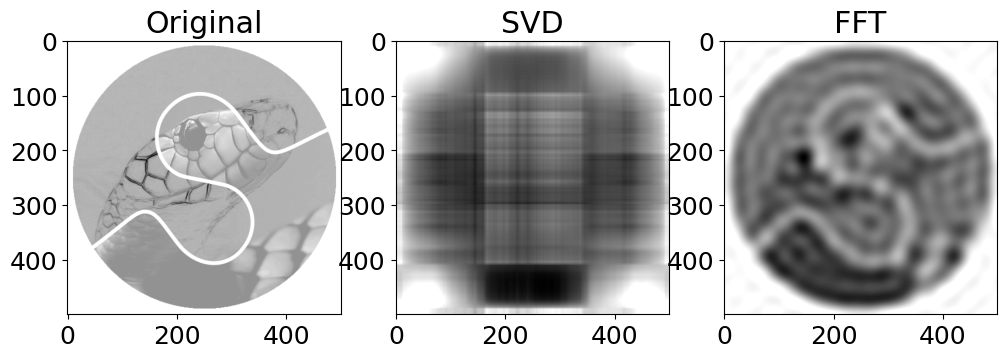

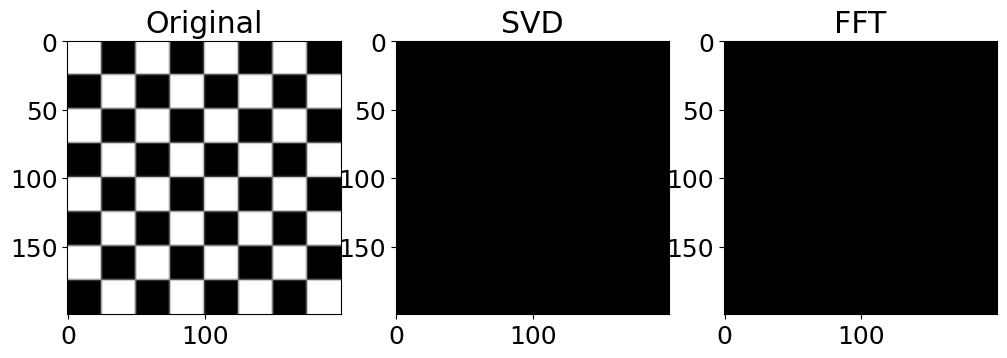

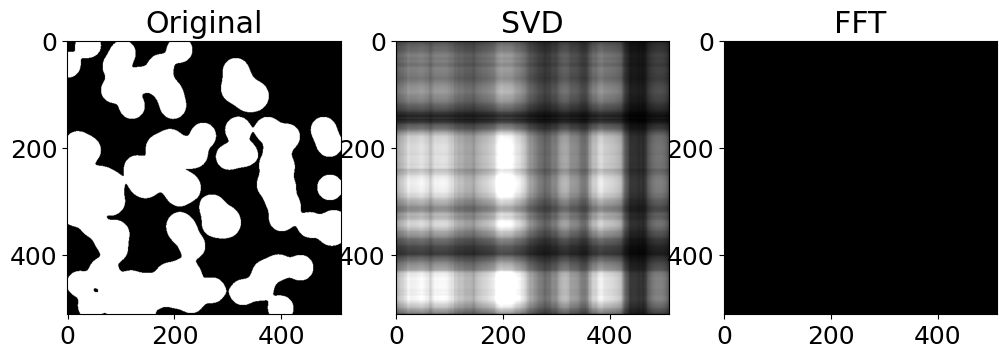

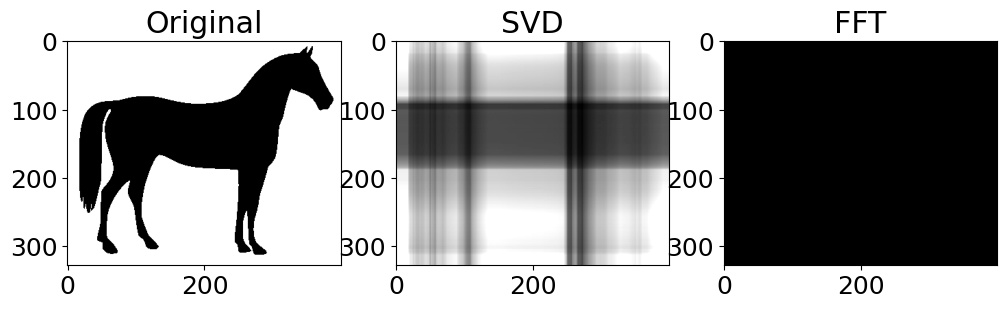

In [26]:
sorted_images = (
    'coffee',
    'coins',
    'astronaut',
    'page',
    'eagle',
    'grass',
    'gravel',
    'camera',
    'cat',
    'colorwheel',
    'rocket',
    'text',
    'clock',
    'brick',
    'logo',
    'checkerboard',
    'binary_blobs',
    'horse')


for name in sorted_images:

    start_time_svd = time.time()
    
    image_array = getattr(data, name)()
    image_grey = image_to_greyscale(image_array)


    target_compression_ratio = 1.5
    
    
    num_singular_values = find_optimal_singular_values(image_grey, target_compression_ratio)
    compressed_image_svd = svd_image_compress(image_grey, num_singular_values)

    elapsed_time_svd = time.time() - start_time_svd

    start_time_fft = time.time()
    
    optimal_radius = find_optimal_radius(image_grey, target_compression_ratio)
    compressed_image_fft = apply_fft_and_mask(image_grey, optimal_radius)
    
    elapsed_time_fft = time.time() - start_time_fft
    
    original_image_filename = f'original_image_{name}.png'
    imageio.imwrite(original_image_filename, image_grey)
    original_image_size = os.path.getsize(original_image_filename)
    
    compressed_image_filename_svd = f'compressed_image_svd_{name}.png'
    imageio.imwrite(compressed_image_filename_svd, compressed_image_svd)
    compressed_image_size_svd = os.path.getsize(compressed_image_filename_svd)
    
    compressed_image_filename_fft = f'compressed_image_fft_{name}.png'
    imageio.imwrite(compressed_image_filename_fft, compressed_image_fft)
    compressed_image_size_fft = os.path.getsize(compressed_image_filename_fft)
    
    # Plotting original and compressed images
    
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_grey, cmap='gray')
    plt.title("Original")
    
    plt.subplot(1, 3, 2)
    plt.imshow(compressed_image_svd, cmap='gray')
    plt.title("SVD")
    
    plt.subplot(1, 3, 3)
    plt.imshow(compressed_image_fft, cmap='gray')
    plt.title("FFT")
    
    # Final compression ratio output
    # print()
    # print(name)
    # print(f"SVD file size is {compressed_image_size_svd}")
    # print(f"FT file size is {compressed_image_size_fft}")
    # print(f"Final Compression Ratio for SVD is {round(original_image_size/compressed_image_size_svd, 2)}")
    # print(f"Final Compression Ratio for FFT is {round(original_image_size/compressed_image_size_fft, 2)}")
    # print(f"Computation time for SVD: {elapsed_time_svd:.2f} seconds")
    # print(f"Computation time for FFT: {elapsed_time_fft:.2f} seconds")
    # print()

# Function to calculate PSNR for compressed images

Here, we write a function to calculate the Peak Signal-to-Noise Ratio for a compressed image. PSNR is one of our primary quantitative metrics defined in the report, and the function uses parameters based on the formula described in the report.

In [27]:
def calculate_psnr(original, compressed):
    
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((original - compressed) ** 2)
    
    # If MSE is zero, the images are identical; return a high PSNR
    if mse == 0:
        return float('inf')
    
    # Calculate the maximum pixel value of the image
    max_pixel_value = 255.0  # Assuming 8-bit grayscale images, max value is 255
    
    # Calculate PSNR
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))
    return psnr


# Plot PSNR & Computation Time for SVD & FT on top 3 candidate images

Here, we calculate the PSNR and Computation Time upon conducting SVD and FT compression on our three chosen candidate images (reasoning explained in the report, Section 5.2). 

For each image in our candidate image list, we constructed a while loop, which iterates through a range of compression_ratio values, starting from 1.0 and ending at 3.0, with a step value of 0.05. 

Then, for each iteration (or, each compression_ratio value), we store the PSNR and Computation Time values for each algorithm in a dictionary, named quantitative_data below. This dictionary will be used for plotting in the later stages of this script.

Finally, for each candidate image, we plot the PSNR against Compression Ratio, and Computation Time against Compression Ratio. Both SVD and FT graphs are displayed on the same plot, for comparison.

The focus is not on qualitative analysis of image quality, and with computational load in mind, we did not display the images at all compression_ratio values defined in the range.

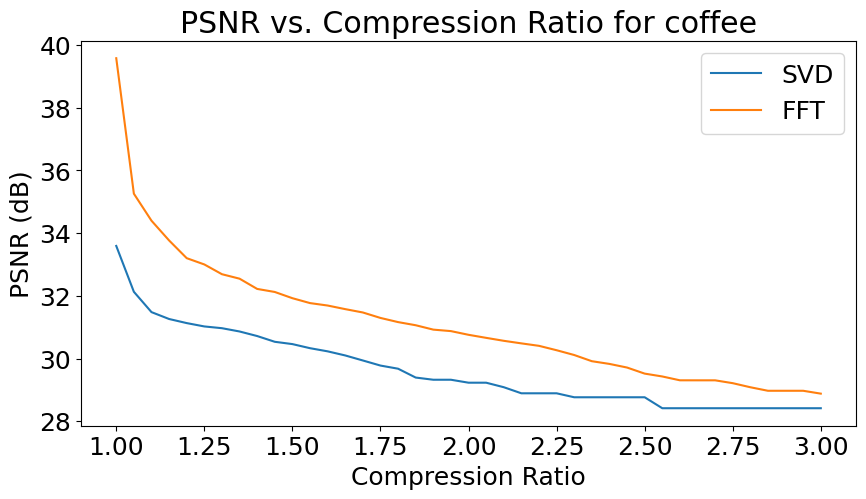

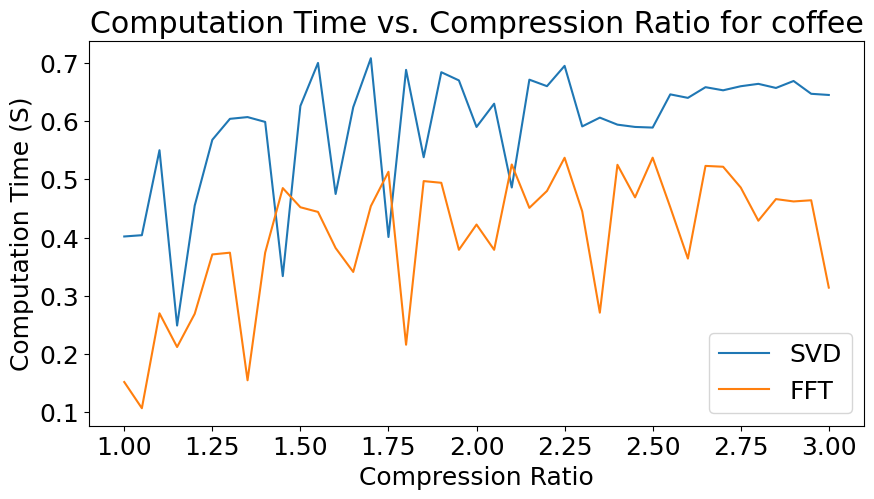

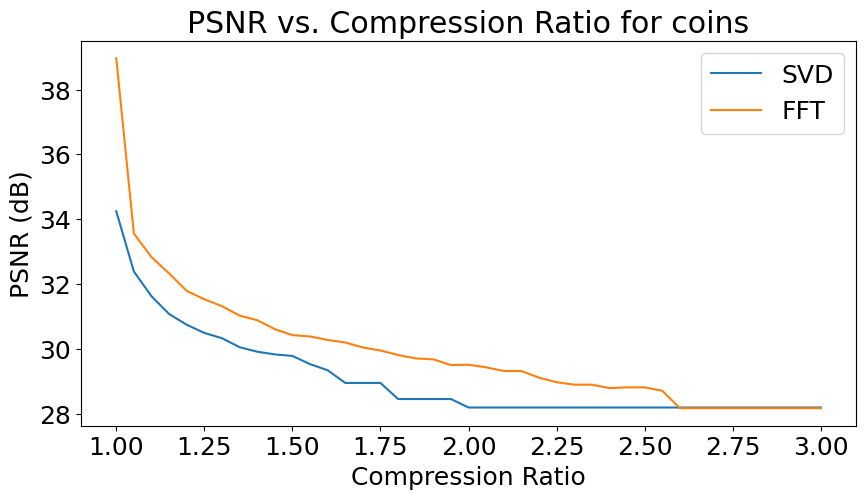

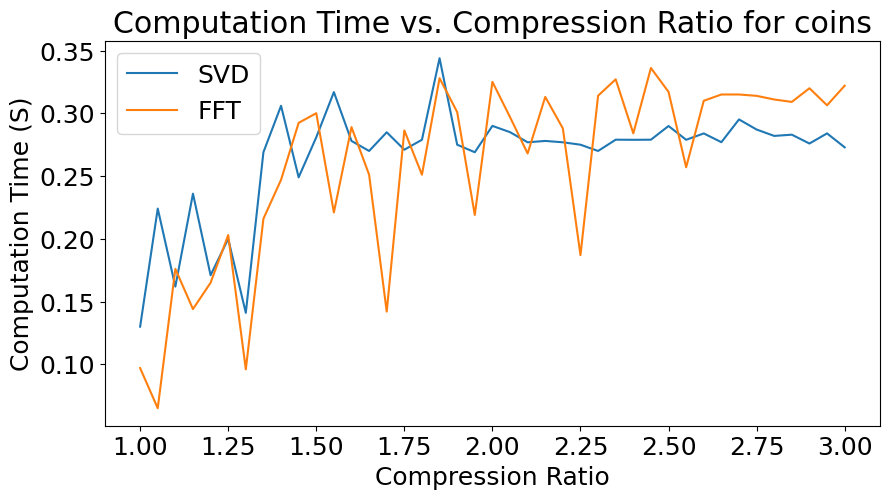

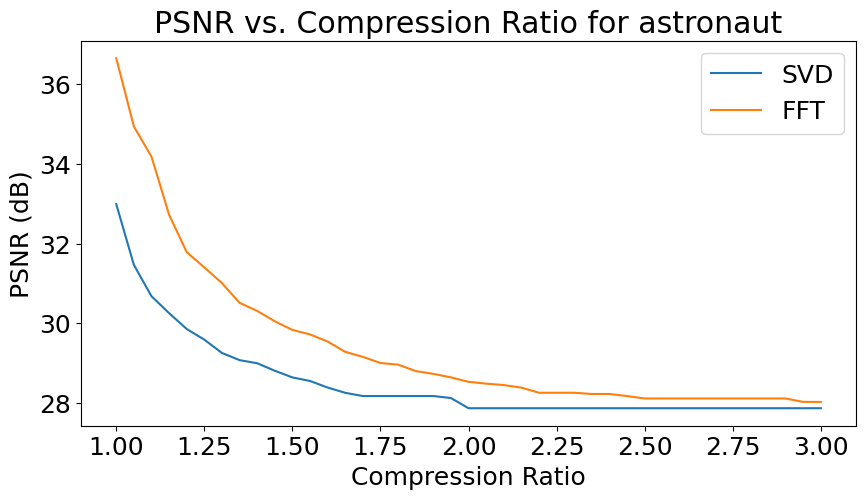

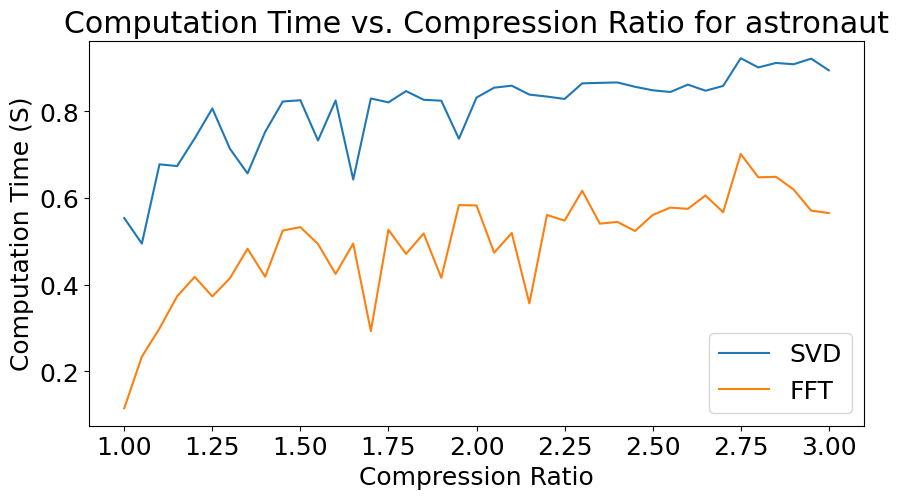

In [28]:

candidate_images = (
    'coffee',
    'coins',
    'astronaut')
    

quantitative_data = {name: {'compression_ratios': [], 'psnr_svd': [], 'psnr_fft': [], 'elapsed_time_svd': [], 'elapsed_time_fft' : []} 
                     for name in candidate_images}


for name in candidate_images:
    
    image_array = getattr(data, name)()
    image_grey = image_to_greyscale(image_array)


    compression_ratio = 1.0  # Starting compression ratio

    while compression_ratio < 3.0:
        
        start_time_svd = time.time()
        
        # Use the current compression_ratio to determine the number of singular values
        num_singular_values = find_optimal_singular_values(image_grey, compression_ratio)
        compressed_image_svd = svd_image_compress(image_grey, num_singular_values)
        
        elapsed_time_svd = time.time() - start_time_svd
    
        # Calculate PSNR for SVD
        psnr_svd = calculate_psnr(image_grey, compressed_image_svd)
        
        start_time_fft = time.time()
        
        # Use the current compression_ratio to determine the optimal radius
        optimal_radius = find_optimal_radius(image_grey, compression_ratio)
        compressed_image_fft = apply_fft_and_mask(image_grey, optimal_radius)
        
        elapsed_time_fft = time.time() - start_time_fft
    
        # Calculate PSNR for FFT
        psnr_fft = calculate_psnr(image_grey, compressed_image_fft)
        
        # Store values for plotting
        quantitative_data[name]['compression_ratios'].append(compression_ratio)
        quantitative_data[name]['psnr_svd'].append(psnr_svd)
        quantitative_data[name]['psnr_fft'].append(psnr_fft)
        quantitative_data[name]['elapsed_time_svd'].append(elapsed_time_svd)
        quantitative_data[name]['elapsed_time_fft'].append(elapsed_time_fft)
        
        # Increment compression ratio
        compression_ratio += 0.05
        


# Plot PSNR vs. Compression Ratio for each image
for name in candidate_images:
    plt.figure(figsize=(10, 5))
    plt.plot(quantitative_data[name]['compression_ratios'], quantitative_data[name]['psnr_svd'], label='SVD')
    plt.plot(quantitative_data[name]['compression_ratios'], quantitative_data[name]['psnr_fft'], label='FFT')
    plt.xlabel('Compression Ratio')
    plt.ylabel('PSNR (dB)')
    plt.title(f'PSNR vs. Compression Ratio for {name}')
    plt.legend()
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(quantitative_data[name]['compression_ratios'], quantitative_data[name]['elapsed_time_svd'], label='SVD')
    plt.plot(quantitative_data[name]['compression_ratios'], quantitative_data[name]['elapsed_time_fft'], label='FFT')
    plt.xlabel('Compression Ratio')
    plt.ylabel('Computation Time (S)')
    plt.title(f'Computation Time vs. Compression Ratio for {name}')
    plt.legend()
    plt.show()